## Import modules

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
import timeit #more accurate than time

#import theano
import tensorflow

from sklearn.decomposition import PCA
import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential, model_from_json, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle

import seaborn as sns
sns.set_style("white")
import os
import json
#import shap


from six.moves import cPickle #Faster than pickle

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configure data

## Load Signal Samples

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the signal
---

Here we will load the samples that we will work with. Notice that all samples have a collumn with "Event Type". This is a default flag with the following correspondence:
1 - Heavy Neutral Lepton;
2 - Dark Photon;
3 - Neutralino;
4 - Neutrino DIS

In [2]:
!wget https://media.githubusercontent.com/media/Switch-bot/TFPA-II/main/Project2/Group2/Q1/kinematic_variables_HNLtoPie_vacuum.dat
Signal = pandas.read_csv("kinematic_variables_HNLtoPie_vacuum.dat")
Signal['target'] = 1.0 # If you are doing a binary separation you can set the
                       # target score as 1.0 for the signal and 0.0 for the background
#Signal[' Decay Mode'] = 1 # Flag that you can use to maintain the samples organized, in case you load several at the same time
print(len(Signal))
Signal.head()

--2023-04-03 12:20:20--  https://media.githubusercontent.com/media/Switch-bot/TFPA-II/main/Project2/Group2/Q1/kinematic_variables_HNLtoPie_vacuum.dat
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1071030 (1.0M) [text/plain]
Saving to: ‘kinematic_variables_HNLtoPie_vacuum.dat’

kinematic_variables 100%[===================>]   1.02M  --.-KB/s    in 0.04s   

2023-04-03 12:20:21 (26.8 MB/s) - ‘kinematic_variables_HNLtoPie_vacuum.dat’ saved [1071030/1071030]

4163


,Mother Total Momentum (GeV/c),Mother Transverse Momentum (GeV/c),Mother Fraction of Transverse Momentum,Opening Angle (rad),Impact Parameter (cm),Daughter1 Total Momentum (GeV/c),Daughter1 Transverse Momentum (GeV/c),Daughter1 Fraction of Transverse Momentum,Daughter2 Total Momentum (GeV/c),Daughter2 Transverse Momentum (GeV/c),Daughter2 Fraction of Transverse Momentum,Decay Z (cm),Decay X (cm),Decay Y (cm),DOCA (cm),Invariant Mass (GeV/c^2),Good Reco,Event Type,target
0,69.299122,0.897183,0.012947,0.044780,1.737440,65.652416,0.788007,0.012003,3.654503,0.182277,0.049877,1922.514447,51.521922,-105.761651,0.012923,0.708239,1,1,1.0
1,12.578769,0.346881,0.027577,0.107703,3.458683,6.583111,0.473843,0.071979,6.016365,0.267068,0.044390,1874.312881,16.979693,-253.878129,0.305847,0.703199,1,1,1.0
2,30.287779,0.697702,0.023036,0.045021,3.533231,12.965756,0.386009,0.029771,17.339514,0.582792,0.033611,237.004801,-67.100333,155.998996,0.392198,0.706741,1,1,1.0
3,83.440796,1.009512,0.012099,0.017047,1.687412,27.004064,0.113070,0.004187,56.467543,0.981839,0.017388,-630.912423,22.643889,74.921350,0.422165,0.706879,1,1,1.0
4,38.844567,0.751968,0.019358,0.033438,5.515253,17.225737,0.623646,0.036204,21.618173,0.240705,0.011134,2169.518897,-171.631366,46.171516,0.215627,0.675695,1,1,1.0


### Load the background

In [3]:
!wget https://media.githubusercontent.com/media/Switch-bot/TFPA-II/main/Project2/Group2/Q1/kinematic_variables_Back_vacuum.dat
Background = pandas.read_csv("kinematic_variables_Back_vacuum.dat")
Background['target'] = 0.0 # Since we set the target score for the Signal as 1.0
                       # we will set it as 0.0 for the background
print(len(Background))
Background.head()

--2023-04-03 12:39:17--  https://media.githubusercontent.com/media/Switch-bot/TFPA-II/main/Project2/Group2/Q1/kinematic_variables_Back_vacuum.dat
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 941227 (919K) [text/plain]
Saving to: ‘kinematic_variables_Back_vacuum.dat’

kinematic_variables 100%[===================>] 919.17K  --.-KB/s    in 0.05s   

2023-04-03 12:39:17 (19.2 MB/s) - ‘kinematic_variables_Back_vacuum.dat’ saved [941227/941227]

3639


,Mother Total Momentum (GeV/c),Mother Transverse Momentum (GeV/c),Mother Fraction of Transverse Momentum,Opening Angle (rad),Impact Parameter (cm),Daughter1 Total Momentum (GeV/c),Daughter1 Transverse Momentum (GeV/c),Daughter1 Fraction of Transverse Momentum,Daughter2 Total Momentum (GeV/c),Daughter2 Transverse Momentum (GeV/c),Daughter2 Fraction of Transverse Momentum,Decay Z (cm),Decay X (cm),Decay Y (cm),DOCA (cm),Invariant Mass (GeV/c^2),Good Reco,Event Type,target
0,53.241568,1.444969,0.027140,0.016163,117.502626,41.236736,1.039827,0.025216,12.133435,0.433589,0.035735,-2420.052545,8.213654,-10.082194,0.729914,0.491374,-1,4,0.0
1,19.097307,0.608527,0.031865,0.017566,142.307863,12.133435,0.433589,0.035735,6.961767,0.190232,0.027325,-2283.114383,9.907318,-11.862951,2.100890,0.331231,-1,4,0.0
2,2.879573,0.220366,0.076527,0.043089,575.086583,2.034240,0.181244,0.089096,0.845269,0.039099,0.046256,-2329.215415,-22.470091,199.587848,18.650839,0.238762,-1,4,0.0
3,11.991372,1.001063,0.083482,0.098067,551.981116,0.219881,0.021883,0.099520,9.374224,0.779975,0.083204,1561.525378,-195.557647,190.659540,185.652281,0.185457,-1,4,0.0
4,1.181279,0.192017,0.162550,0.199059,1599.715738,0.662225,0.073975,0.111707,0.524484,0.117011,0.223098,1519.352893,161.238355,80.517033,13.364248,0.303275,-1,4,0.0


<ipython-input-5-a404705f35d9>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(x, hist_kws={"range": ranges[col]}, norm_hist = True, kde=False, label = "Signal")#, fit=stats.gamma);
<ipython-input-5-a404705f35d9>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y, hist_kws={"range":

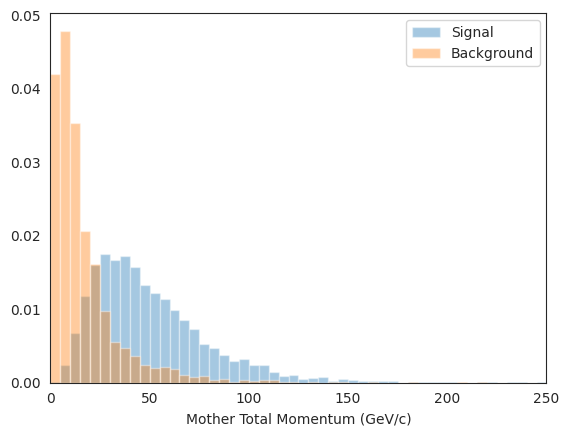

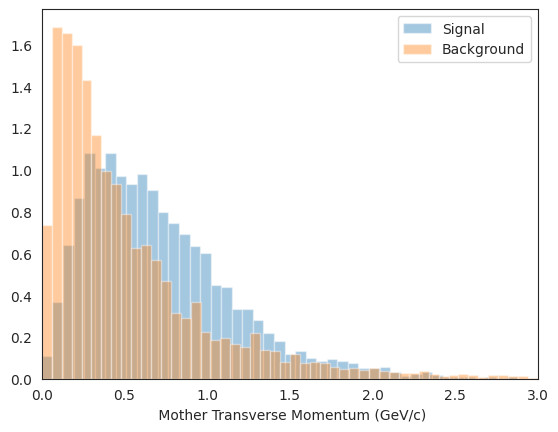

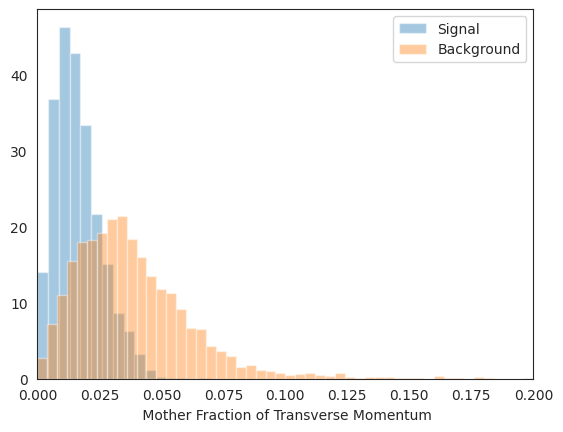

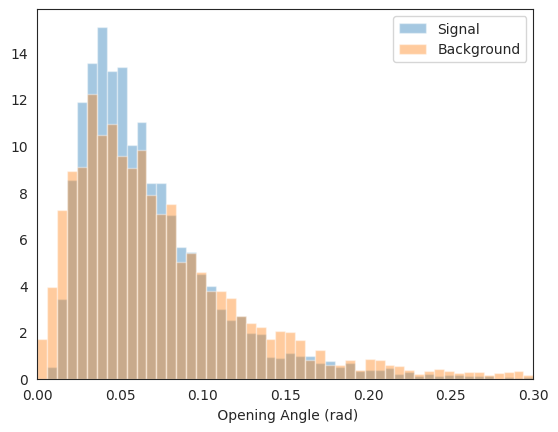

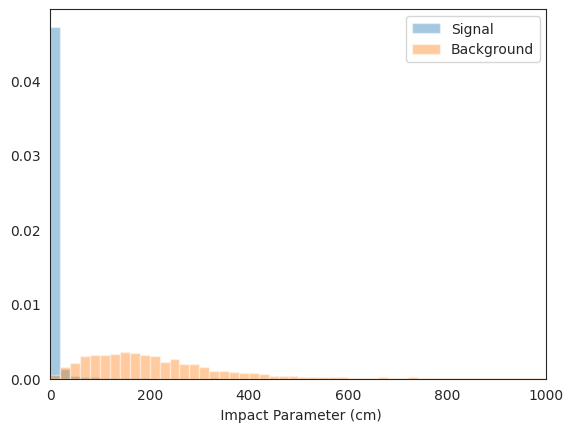

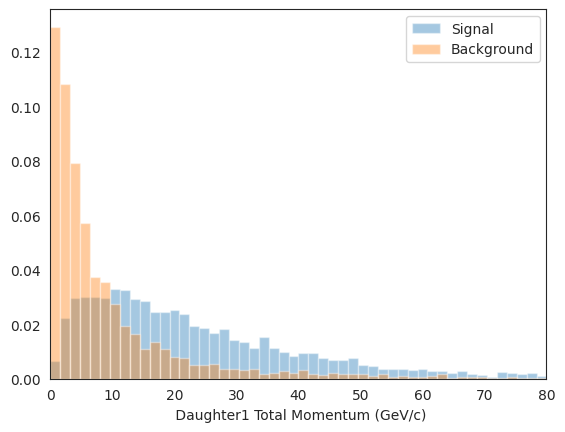

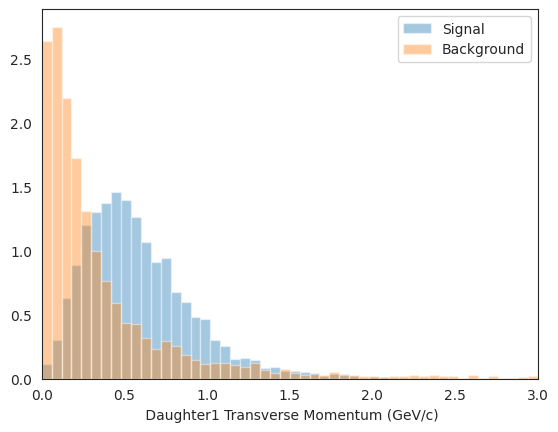

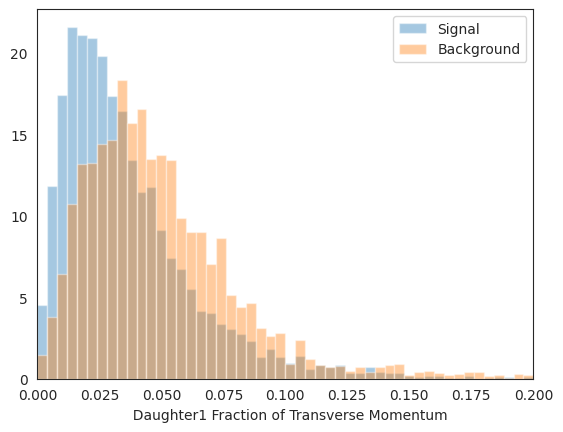

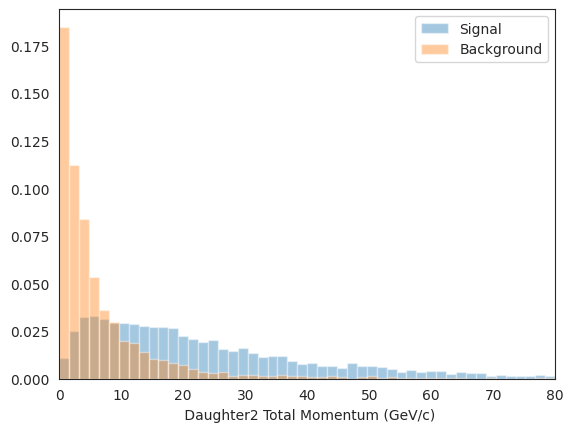

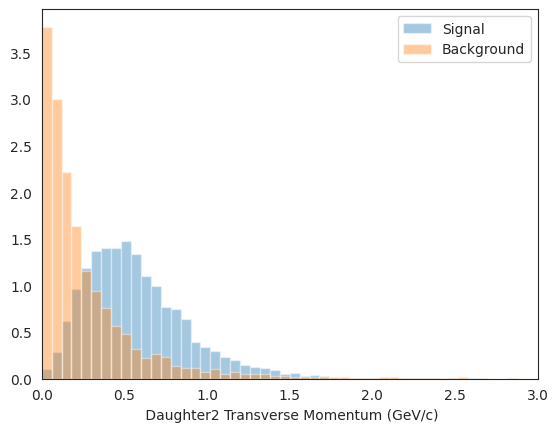

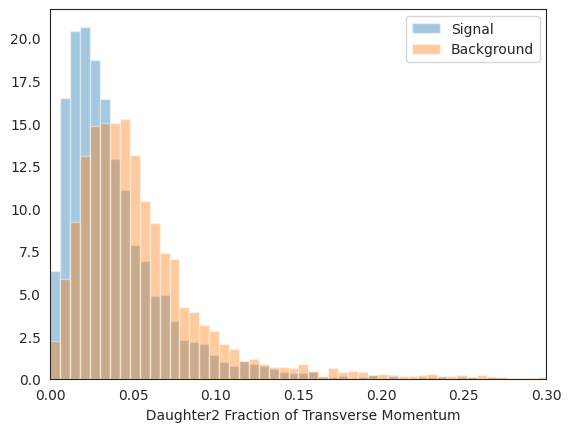

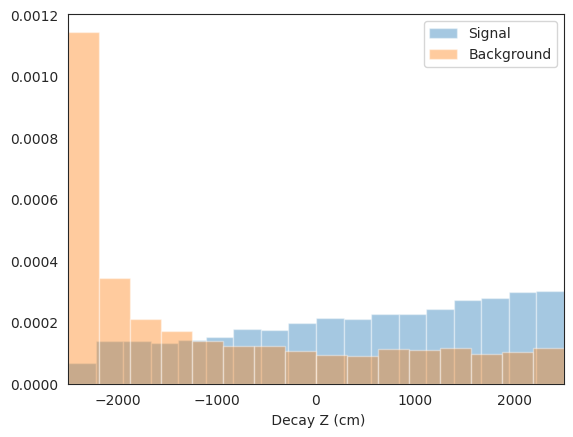

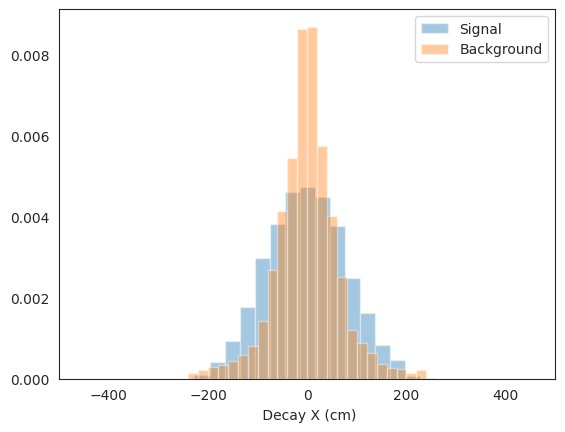

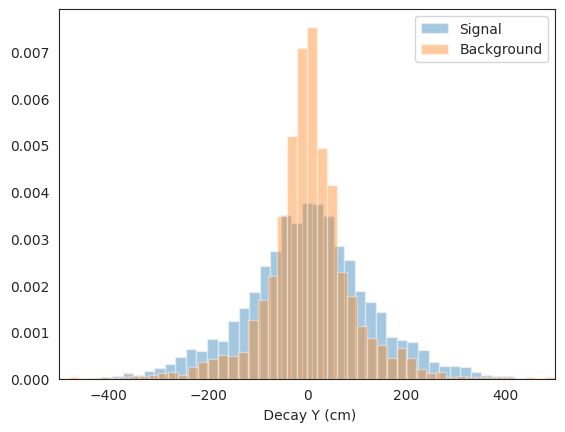

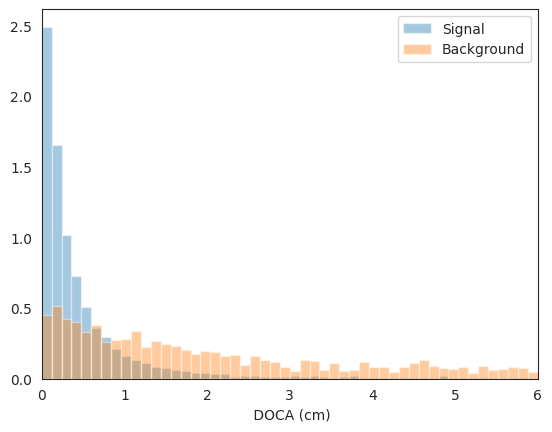

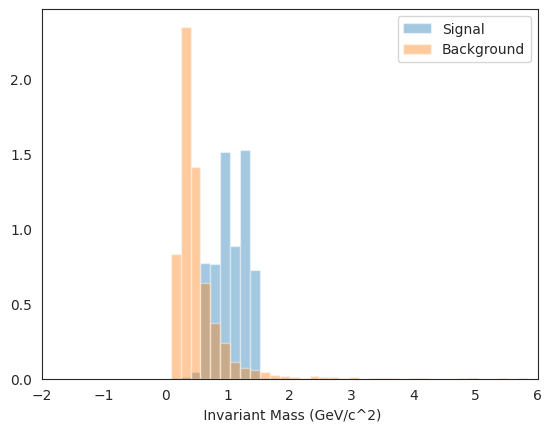

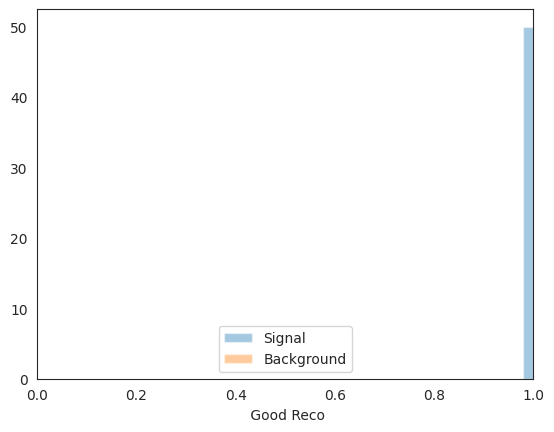

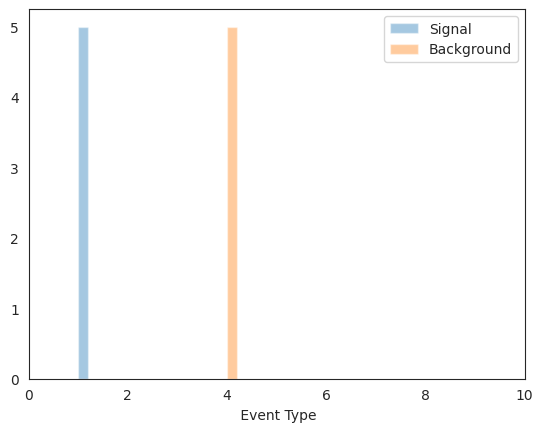

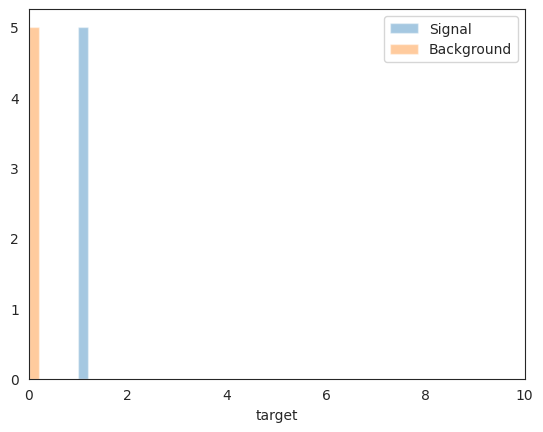

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/TFPA-II/Project 2/feature plots/')    
os.system("rm *.png")

ranges = dict()
r = [[0,250], [0,3], [0,0.2], [0,0.3], [0,1000], [0,80], [0,3], [0,0.2], [0,80], [0,3], [0,0.3],[-2500,2500], [-500, 500], [-500, 500], [0,6], [-2, 6], [0,1]]
for i, col in enumerate(Signal.columns):
    try:
        ranges[col] = r[i]
    except:
        ranges[col] = [0,10]
    

for i,col in enumerate(Signal.columns):
  plt.figure(i)
  x = Signal[col]
  y = Background[col]
  ax = sns.distplot(x, hist_kws={"range": ranges[col]}, norm_hist = True, kde=False, label = "Signal")#, fit=stats.gamma);
  ax = sns.distplot(y, hist_kws={"range": ranges[col]}, norm_hist = True, kde=False, label = "Background")#, fit=stats.gamma);
  ax.set_xlim(ranges[col][0],ranges[col][1])
  plt.legend()
  feat='feature'+ str(i)
    
  plt.savefig(feat)
 


<ipython-input-7-33069b7960de>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(testx, hist_kws={"range": [0,50] }, norm_hist = True, kde=False, label = "Signal")#, fit=stats.gamma);
<ipython-input-7-33069b7960de>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(testy, hist_kws={"range

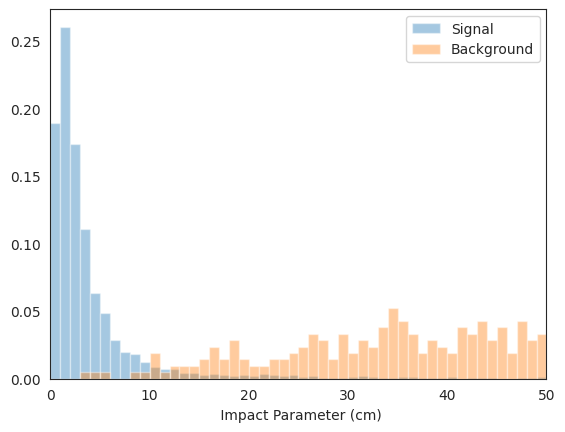

In [ ]:
#zoom into the impact parameter plot
plt.figure(1)
testx = Signal[' Impact Parameter (cm)']
testy = Background[' Impact Parameter (cm)']
ax = sns.distplot(testx, hist_kws={"range": [0,50] }, norm_hist = True, kde=False, label = "Signal")#, fit=stats.gamma);
ax = sns.distplot(testy, hist_kws={"range": [0,50]  }, norm_hist = True, kde=False, label = "Background")#, fit=stats.gamma);
ax.set_xlim(0,50)
plt.legend()

In [4]:
CutSignal=Signal[(Signal[' Impact Parameter (cm)']<=25)]
CutBackground=Background[(Background[' Impact Parameter (cm)']<= 25)]
print('Signal: ' + str(len(CutSignal))+ ' out of ' + str(len(Signal)) + ' aka efficiency of ' + str(float(len(CutSignal))/float(len(Signal))))
print('Background: ' + str(len(CutBackground))+ ' out of ' + str(len(Background)))


Signal: 3978 out of 4163 aka efficiency of 0.955560893586356
Background: 50 out of 3639


In [5]:
CutSignal=Signal[(Signal[' DOCA (cm)']<3)]
CutBackground=Background[(Background[' DOCA (cm)']<3)]
print('Signal: ' + str(len(CutSignal))+ ' out of ' + str(len(Signal)) + ' aka efficiency of ' + str(float(len(CutSignal))/float(len(Signal))))
print('Background: ' + str(len(CutBackground))+ ' out of ' + str(len(Background)))


Signal: 3978 out of 4163 aka efficiency of 0.955560893586356
Background: 1069 out of 3639


In [ ]:
CutSignal=Signal[(Signal[' Decay Z (cm)']>-2000)]
CutBackground=Background[(Background[' Decay Z (cm)']>-2000)]
print('Signal: ' + str(len(CutSignal))+ ' out of ' + str(len(Signal)) + ' aka efficiency of ' + str(float(len(CutSignal))/float(len(Signal))))
print('Background: ' + str(len(CutBackground))+ ' out of ' + str(len(Background)))


Signal: 3955 out of 4163 aka efficiency of 0.950036031707903
Background: 2084 out of 3639


In [86]:
besteff=0
for i in range(20):
  for j in range(20):
    for k in range(20):
        aa=[25+0.1*i,25-0.1*i]
        bb=[10-0.1*j,10+0.1*j]
        c=-2500+k*10
        for a in aa:
          for b in bb:
            CutSignal=Signal[(Signal[' Impact Parameter (cm)']<=a) & (Signal[' DOCA (cm)']<b) & (Signal[' Decay Z (cm)']>c)]
            CutBackground=Background[(Background[' Impact Parameter (cm)']<= a) & (Background[' DOCA (cm)']<b) & (Background[' Decay Z (cm)']>c)]
            if (float(len(CutSignal))/float(len(Signal))>=besteff) & (len(CutBackground)<=10):
              besteff=float(len(CutSignal))/float(len(Signal))
              print(besteff)
              abest=a
              bbest=b
              cbest=c
              break
CutSignal=Signal[(Signal[' Impact Parameter (cm)']<=abest) & (Signal[' DOCA (cm)']<bbest) & (Signal[' Decay Z (cm)']>cbest)]
CutBackground=Background[(Background[' Impact Parameter (cm)']<= abest) & (Background[' DOCA (cm)']<bbest) & (Background[' Decay Z (cm)']>cbest)]    
print('a='+str(abest)+' b='+str(bbest) + ' c='+ str(cbest))
print('Signal: ' + str(len(CutSignal))+ ' out of ' + str(len(Signal)) + ' aka efficiency of ' + str(float(len(CutSignal))/float(len(Signal))))
print('Background: ' + str(len(CutBackground))+ ' out of ' + str(len(Background)))


0.9442709584434302
0.9442709584434302
0.9445111698294499
0.9447513812154696
0.9447513812154696
0.9449915926014893
0.9449915926014893
0.9452318039875091
0.9452318039875091
0.9452318039875091
0.9452318039875091
0.9452318039875091
0.9454720153735287
0.9457122267595484
0.9457122267595484
0.9459524381455681
0.9459524381455681
0.9459524381455681
0.9466730723036272
0.9466730723036272
a=26.8 b=10.0 c=-2370
Signal: 3941 out of 4163 aka efficiency of 0.9466730723036272
Background: 10 out of 3639


In [87]:
totalbkg=1000
for i in range(20):
  for j in range(20):
    for k in range(20):
        aa=[25+0.1*i,25-0.1*i]
        bb=[10-0.1*j,10+0.1*j]
        c=-2500+k*10
        for a in aa:
          for b in bb:
            CutSignal=Signal[(Signal[' Impact Parameter (cm)']<=a) & (Signal[' DOCA (cm)']<b) & (Signal[' Decay Z (cm)']>c)]
            CutBackground=Background[(Background[' Impact Parameter (cm)']<= a) & (Background[' DOCA (cm)']<b) & (Background[' Decay Z (cm)']>c)]
            if (float(len(CutSignal))/float(len(Signal))>=0.95) & (len(CutBackground)<totalbkg):
              totalbkg=len(CutBackground)
              print(totalbkg)
              abest=a
              bbest=b
              cbest=c
              break
CutSignal=Signal[(Signal[' Impact Parameter (cm)']<=abest) & (Signal[' DOCA (cm)']<bbest) & (Signal[' Decay Z (cm)']>cbest)]
CutBackground=Background[(Background[' Impact Parameter (cm)']<= abest) & (Background[' DOCA (cm)']<bbest) & (Background[' Decay Z (cm)']>cbest)]    
print('a='+str(abest)+' b='+str(bbest) + ' c='+ str(cbest))
print('Signal: ' + str(len(CutSignal))+ ' out of ' + str(len(Signal)) + ' aka efficiency of ' + str(float(len(CutSignal))/float(len(Signal))))
print('Background: ' + str(len(CutBackground))+ ' out of ' + str(len(Background)))


29
25
24
23
21
20
a=26.4 b=11.7 c=-2450
Signal: 3955 out of 4163 aka efficiency of 0.950036031707903
Background: 20 out of 3639


### Fixing and merging our datasets
Since these two template samples are not written in the same format we will do a bit of fixing to merge them correctly before proceeding with the ML

In [6]:
#Background.rename(columns={" Event type":" Event Type"}, inplace=True)
#Signal.rename(columns={"  Daughter1 Fraction of Transverse Momentum":" Daughter1 Fraction of Transverse Momentum", "  Daughter2 Fraction of Transverse Momentum":" Daughter2 Fraction of Transverse Momentum"}, inplace=True)
FullSignal = pandas.concat([Signal,Background], ignore_index=True)
#FullSignal.drop(" DOCA (cm)" ,axis=1, inplace=True)
#FullSignal.drop(" Invariant Mass (GeV/c^2)" ,axis=1, inplace=True)
FullSignal

,Mother Total Momentum (GeV/c),Mother Transverse Momentum (GeV/c),Mother Fraction of Transverse Momentum,Opening Angle (rad),Impact Parameter (cm),Daughter1 Total Momentum (GeV/c),Daughter1 Transverse Momentum (GeV/c),Daughter1 Fraction of Transverse Momentum,Daughter2 Total Momentum (GeV/c),Daughter2 Transverse Momentum (GeV/c),Daughter2 Fraction of Transverse Momentum,Decay Z (cm),Decay X (cm),Decay Y (cm),DOCA (cm),Invariant Mass (GeV/c^2),Good Reco,Event Type,target
0,69.299122,0.897183,0.012947,0.044780,1.737440,65.652416,0.788007,0.012003,3.654503,0.182277,0.049877,1922.514447,51.521922,-105.761651,0.012923,0.708239,1,1,1.0
1,12.578769,0.346881,0.027577,0.107703,3.458683,6.583111,0.473843,0.071979,6.016365,0.267068,0.044390,1874.312881,16.979693,-253.878129,0.305847,0.703199,1,1,1.0
2,30.287779,0.697702,0.023036,0.045021,3.533231,12.965756,0.386009,0.029771,17.339514,0.582792,0.033611,237.004801,-67.100333,155.998996,0.392198,0.706741,1,1,1.0
3,83.440796,1.009512,0.012099,0.017047,1.687412,27.004064,0.113070,0.004187,56.467543,0.981839,0.017388,-630.912423,22.643889,74.921350,0.422165,0.706879,1,1,1.0
4,38.844567,0.751968,0.019358,0.033438,5.515253,17.225737,0.623646,0.036204,21.618173,0.240705,0.011134,2169.518897,-171.631366,46.171516,0.215627,0.675695,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7797,6.801441,0.242971,0.035723,0.003694,199.667017,1.382475,0.045812,0.033138,5.418165,0.196412,0.036251,700.670489,57.688520,68.826882,3.241300,0.331550,-1,4,0.0
7798,12.034546,0.595302,0.049466,0.036048,201.717555,9.386960,0.460034,0.049008,2.641962,0.157516,0.059621,-2333.437344,-65.571576,150.615987,7.743315,0.327161,-1,4,0.0
7799,22.350196,0.918840,0.041111,0.015536,254.339205,16.828812,0.690480,0.041030,5.406403,0.242659,0.044884,-1557.463523,18.344480,21.590345,12.141207,0.287947,-1,4,0.0
7800,4.723379,0.059261,0.012546,0.050684,255.495322,3.956148,0.065179,0.016475,0.761470,0.036173,0.047504,901.186610,-66.701987,-172.015640,100.339121,0.314454,-1,4,0.0


## Create development and validation samples

### Normalize the samples

Before creating the validation and development samples we need to normalize our dataset, since the normalization methods are done in respect to the sample fed to the pipeline. This means that if we select subsamples first and normalize them afterwards, the normalization will be slightly different every time.

Here we define a SK-Learn pipeline which will contain transformation steps for any data fed in. Pipelines are a nice, compact way of handing data transformations.

In [7]:
normIn = True #True #Whether we want to normalise and standardise the inputs
pca = True #True #Whether we want to use principal-component analysis to decorrelate inputs
whiten = True #True #Whether we want to whiten input data

stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []

In order to normalize our data we need to define which variables we want to use in our analysis. We define those in the block below

In [8]:
#The columns in the file are separated by ", " so since this reads it as a .csv file the spaces count in the names
#Features = [var for var in FullSignal.columns if str.startswith(var, " Event") or str.startswith(var, " Decay Angle") or str.startswith(var, "target") or str.startswith(var, " Decay Mode") or str.startswith(var, " Decay X") or str.startswith(var, " Decay Y") or
#            str.startswith(var, " Daughter1 Fraction") or str.startswith(var, " Daughter2 Fraction") or str.startswith(var, " Mother Transverse") or str.startswith(var, " Good") or str.startswith(var, " Invariant")] #introduzir todas as variáveis que pretendes excluir do treino
#trainFeatures = [var for var in FullSignal.columns if var not in Features] #Reconstructed features; ok for training
trainFeatures = [var for var in FullSignal.columns if str.startswith(var, "Mother Total") or str.startswith(var," Impact Parameter") or str.startswith(var," DOCA") or str.startswith(var," Mother Fraction") or str.startswith(var," Decay Z")]


print(trainFeatures)

['Mother Total Momentum (GeV/c)', ' Mother Fraction of Transverse Momentum', ' Impact Parameter (cm)', ' Decay Z (cm)', ' DOCA (cm)']


We put the normalized data into NormFullSignal, and only afterwards do we create our test and validation samples


In [9]:
#Recall that the output from NormFullSignal is an array (numpy like)
NormFullSignal = inputPipe.fit_transform(FullSignal[trainFeatures].values.astype('float32'))

#Notice that since we normalized our data and applied a PCA the variables are no longer physical, and also would not have units
#However, in order to create a dataframe we need a placeholder name for each column, and this is practical
NormFullSignalDF = pandas.DataFrame(NormFullSignal, columns=trainFeatures)

#We are using iloc in order to select from event iloc[first_event:last_event,first_column:last_column], 
NormSignal = NormFullSignalDF.iloc[0:len(Signal),:]
NormBackground = NormFullSignalDF.iloc[len(Signal):len(FullSignal),:]

### Creating the samples to test and validate our NN
We look at what data-set has the least events, and select an analogous amount of the other set randomly to avoid bias towards one

Here we divide our samples into a 60/20/20 split in order to train with a part of our subset, and validate our model with the other part.

In [10]:
NormSignal['target'] = 1.0
NormBackground['target'] = 0.0

sigratio = 1
backratio = 1
if len(Signal) < len(Background):
  backratio = len(Signal)/len(Background)
  print(backratio)
else:
  sigratio = len(Background)/len(Signal)
  print(sigratio)


# Creates a column that defines the target score that we want to achieve in each data set
# This is a good way of dividing the datasets when they are relatively similar in sizes
Sig_train, Sig_test = \
                train_test_split([i for i in NormSignal.index.tolist()],
                                 test_size=(1-0.8*sigratio), random_state=1337)
Back_train, Back_test = \
                train_test_split([i for i in NormBackground.index.tolist()],
                                 test_size=(1-0.8*backratio), random_state=1337)

trainSig = NormSignal.loc[Sig_train].copy()
trainBack = NormBackground.loc[Back_train].copy()
testData = NormSignal.loc[Sig_test].copy()
testData = testData.append(NormBackground.loc[Back_test].copy(), ignore_index = True)

# First we randomly divide the data into 80/20, and set 20% aside to test our NN
# and then with the reamining 80% we divide it into 60/20, with 60% to train the
# NN and 20% for the validation sample

Sig_dev, Sig_val = \
                train_test_split([i for i in trainSig.index.tolist()],
                                 test_size=(1-0.75), random_state=1337)
Back_dev, Back_val = \
                train_test_split([i for i in trainBack.index.tolist()],
                                 test_size=(1-0.75), random_state=1337)

devData = trainSig.loc[Sig_dev].copy()
devData = devData.append(trainBack.loc[Back_dev].copy(), ignore_index = True)
valData = trainSig.loc[Sig_val].copy()
valData = valData.append(trainBack.loc[Back_val].copy(), ignore_index = True)

print(len(Sig_train))
print(len(Back_train))
print(len(Sig_dev))
print(len(Back_dev))
print(len(Sig_val))
print(len(Back_val))
print(len(Sig_test))
print(len(Back_test))

0.8741292337256786
2911
2911
2183
2183
728
728
1252
728


<ipython-input-10-8162d4cdd5f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NormSignal['target'] = 1.0
<ipython-input-10-8162d4cdd5f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NormBackground['target'] = 0.0
<ipython-input-10-8162d4cdd5f8>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  testData = testData.append(NormBackground.loc[Back_test].copy(), ignore_index = True)
<ipython-input-10-8162d4cdd5f8>:40:

After all of this, we create the training and validation arrays that will be fed onto the network

In [11]:
Features1 = [var for var in devData.columns if str.startswith(var, "target")]

X_class_train = devData[trainFeatures].values.astype('float32')
y_class_train = devData[Features1].values.astype('float32')

X_class_val = valData[trainFeatures].values.astype('float32')
y_class_val = valData[Features1].values.astype('float32')

X_class_test = testData[trainFeatures].values.astype('float32')
y_class_test = testData[Features1].values.astype('float32')

#print(trainFeatures)
#print(Features1)
#devData

## Training options

Training options for a binary separation

In [ ]:
classTrainFeatures = trainFeatures #The features used
classModel = "model0" #Will define the layout of the network
varSet = "trainFeatures" #Name of the feature set used, mainly for saving results
nSplits = 1 #Number of train/test splits to make during cross-validation
ensembleSize = 1 #Number of classifiers  to include in ensemble = min(nSplits, ensembleSize)
ensembleMode = 'loss'#accuracy'#'loss' #Metric used to weight classifiers in ensemble
#nad=Nadam(0.0001, 0.9, 0.999, 1e-08, 0.004)
nad=Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#sgd=SGD(0.001,0.0,0.0,False)
sgd=SGD(learning_rate=0.001,momentum=0.9,nesterov=True)
#categorical_cross_entropy para várias amostras de sinal
compileArgs = {'loss':'binary_crossentropy', 
               'optimizer':'Adam'}#, 'metrics':['acc']} #Loss function and optimiser for NN
trainParams = {'epochs' : 300, 
               'batch_size' : 100, 
               'verbose' : 2} #Maximum epochs for training and size of mini-batch
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))

Training on 5 features ['Mother Total Momentum (GeV/c)', ' Mother Fraction of Transverse Momentum', ' Impact Parameter (cm)', ' Decay Z (cm)', ' DOCA (cm)']


## Define classifier

Classifier for the binary separation

In [ ]:

def getClassifier(model, nIn, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    if model == "model0":
        depth = 3
        width = 25
        step = 5
    #classModel.add(Dropout(0.2))
    classModel.add(Dense(width, input_shape=(5,), kernel_initializer='normal', activation='relu'))#, kernel_initializer='TruncatedNormal')) #First layer requires number of inputs
    classModel.add(Activation('relu')) #Add ReLU activation function
    for i in range(depth): #Continue to add hidden layers 
        width = width-step
        print(width)
        classModel.add(Dropout(0.05))
        classModel.add(Dense(width, kernel_initializer='normal', activation='relu'))#kernel_initializer='TruncatedNormal') #Subsequent layers inherit input_dim from previous layer
        #classModel.add(Activation('relu'))
    #classModel.add(Dropout(0.2))
    classModel.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))#, kernel_initializer='TruncatedNormal')) #Final layer requires one output
    #Change this to put a number of neurons equal to the number of categories and change sigmoid to softmax
    classModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    return classModel

### Callbacks

Callbacks are methods that can be called during training. They have a variety of uses such as monitoring training, stopping training early, and saving different versions of the model. Here we define our own callback,  which saves the history of the training.

We want to view the history of the model's performance on the training and testing data during data, however by default the training loss is averaged over the epoch, and the test loss is evaluated at the end of the epoch, so is not comparable. This modified version evaluates the performance on the training data at the end of each epoch.

Later well also use some other callbacks:

EarlyStopping monitors a specified metric and stops the training if the performance fails to improve for a specified number of epochs in a row. Here we use it to monitor the loss on the test data and stop when it doesn't improve after 10 epochs.

ModelCheckpoint is used to save the weights of the network during training. It's quite flexible, but here we use it save the model which performs best according to the loss in test data.

Normally during training, the test loss will reach a minimum and either saturate or start to increase (overtraining). The training loss will normally either saturate or continue to decrease. The optimum point is when the test-loss first reaches its minimum point. The combination of EarlyStopping and ModelCheckpoint acts to save the model at this point and allow some leeway in case it starts to decrease again.

In [ ]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [ ]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

## Train classifier

In [ ]:

#W_final = np.array(W)

start = timeit.default_timer()

results = []
histories = []
os.chdir('/content/drive/MyDrive/Colab Notebooks/TFPA-II/Project 2/ML_Weights') #Here you should put the directory in your pc where you will save the weight files for the NNs

os.system("mkdir train_weights_300ep_50pat")
os.system("rm train_weights_300ep_50pat/*.h5")
os.system("rm train_weights_300ep_50pat/*.json")
os.system("rm train_weights_300ep_50pat/*.pkl")

model = None # Clearing the NN
model = getClassifier(classModel, len(classTrainFeatures), compileArgs)
#model.reset_states #Just checking
    
lossHistory = LossHistory((X_class_train, y_class_train))
earlyStop = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=True, mode='auto', period=1)
    
#Begin training the model
C = model.fit(X_class_train, y_class_train, validation_data = (X_class_val, y_class_val), callbacks = [earlyStop, saveBest, lossHistory], **trainParams)
    
histories.append(lossHistory.losses) #Saves the loss history from callback
model.load_weights("train_weights/best.h5") #Loads the best model saved by ModelCheckpoint
       
results.append({})
    
results[-1]['loss'] = model.evaluate(X_class_val, y_class_val, verbose=0) #Gets loss on test data
#results[-1]['AUC'] = 1-roc_auc_score(y_class_val, model.predict(X_class_val, verbose=0)) #Gets ROC AUC for test data
 
#print("Score is:", results[-1])
    
model.save('train_weights/train.h5') #Save the model

with open('train_weights/resultsFile.pkl', 'wb') as fout: #Save results
    cPickle.dump(results, fout)

print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))

model.summary() #Prints a summary of the model layout
model = None



20
15
10
Epoch 1/300
44/44 - 2s - loss: 0.6920 - val_loss: 0.6865 - 2s/epoch - 44ms/step
Epoch 2/300
44/44 - 1s - loss: 0.6327 - val_loss: 0.4989 - 501ms/epoch - 11ms/step
Epoch 3/300
44/44 - 0s - loss: 0.2829 - val_loss: 0.1492 - 359ms/epoch - 8ms/step
Epoch 4/300
44/44 - 1s - loss: 0.1251 - val_loss: 0.0971 - 510ms/epoch - 12ms/step
Epoch 5/300
44/44 - 0s - loss: 0.0925 - val_loss: 0.0714 - 345ms/epoch - 8ms/step
Epoch 6/300
44/44 - 0s - loss: 0.0805 - val_loss: 0.0650 - 360ms/epoch - 8ms/step
Epoch 7/300
44/44 - 0s - loss: 0.0792 - val_loss: 0.0603 - 377ms/epoch - 9ms/step
Epoch 8/300
44/44 - 1s - loss: 0.0748 - val_loss: 0.0562 - 508ms/epoch - 12ms/step
Epoch 9/300
44/44 - 1s - loss: 0.0692 - val_loss: 0.0540 - 515ms/epoch - 12ms/step
Epoch 10/300
44/44 - 1s - loss: 0.0678 - val_loss: 0.0537 - 503ms/epoch - 11ms/step
Epoch 11/300
44/44 - 0s - loss: 0.0684 - val_loss: 0.0530 - 370ms/epoch - 8ms/step
Epoch 12/300
44/44 - 0s - loss: 0.0642 - val_loss: 0.0515 - 343ms/epoch - 8ms/step
E

## Construct ensemble
During the *k*-fold CV we trained *k* models. We could just use the best one, however it is unlikely to optimimum for all input possibilities. Ensembling is a method of using multiple classifiers together to achieve a better result than a single one on its own.

The method I use here is to weight the contributions of each classifier according to how well it performed on its test set during CV.

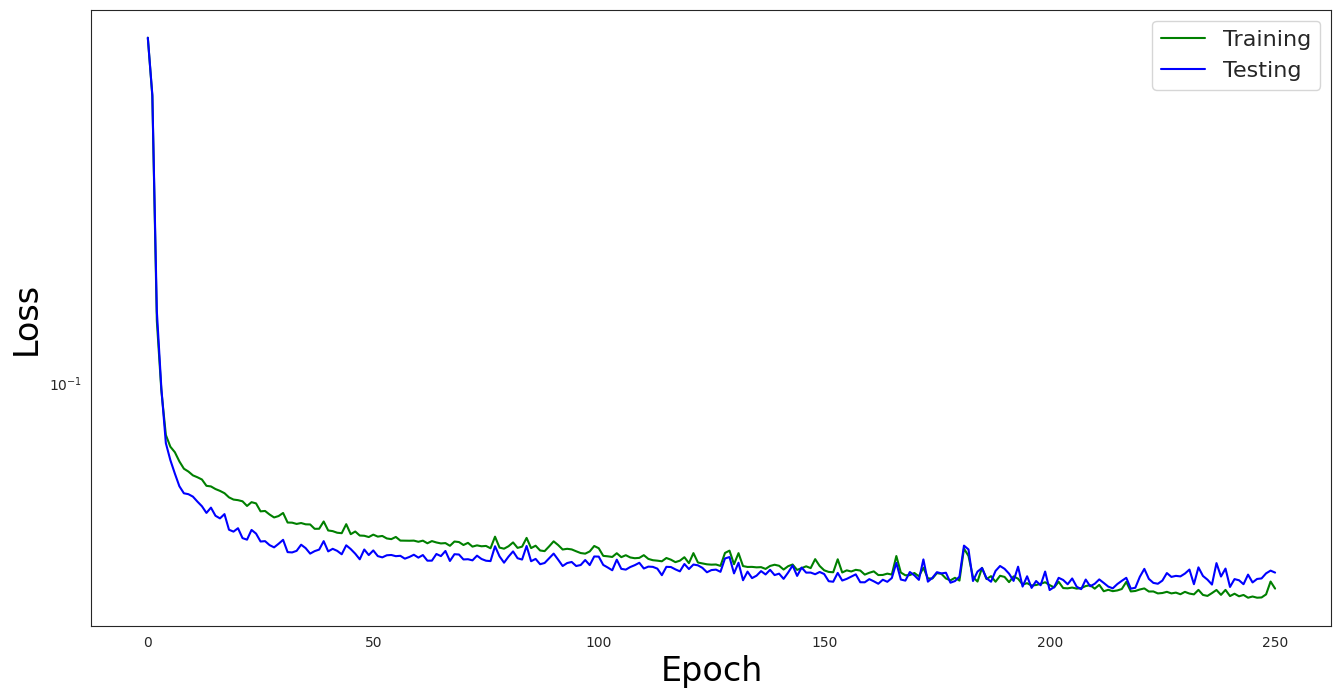

In [ ]:
plt.figure(figsize=(16,8))
#print(model.predict(X_class))
for i, history in enumerate(histories):
    if i == 0:
        plt.plot(history['loss'], color='g', label='Training')
        plt.plot(history['val_loss'], color='b', label='Testing')
    else:
        plt.plot(history['loss'], color='g')
        plt.plot(history['val_loss'], color='b')
        
plt.legend(fontsize=16)
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("Loss", fontsize=24, color='black')
plt.yscale('log')
plt.show()

# Accessing Previous NNs and Applying them to Data

In [12]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/TFPA-II/Project 2/ML_Weights/')
results = None
with open('train_weights_300ep_50pat/resultsFile.pkl', 'rb') as fin: #Reload results in case notebook was closed
    results = cPickle.load(fin)

In [13]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/TFPA-II/Project 2/ML_Weights/train_weights_300ep_50pat/train.h5')

## Response on dev and val data

In [14]:
# Applying our data to the NNs in order to get an array with the score (probability) of it being a signal event
pred_train = model.predict(X_class_train, verbose=0)
pred_val = model.predict(X_class_val, verbose=0)
pred_full_Data = model.predict(NormFullSignal, verbose=0)
pred_test = model.predict(X_class_test, verbose=0)

#devAUC = roc_auc_score(y_class_train[:,0], pred_train[:,0])
#print('Area under ROC curve for development data is {:.5f}'.format(devAUC))

#valAUC = roc_auc_score(y_class_val[:,0], pred_val[:,0])
#print('Area under ROC curve for validation data is {:.5f}'.format(valAUC))

#testAUC = roc_auc_score(y_class_test[:,0], pred_test[:,0])
#print('Area under ROC curve for test data is {:.5f}'.format(testAUC))

#FullSignalScore = FullSignal['target'].values.astype('float32') 
#fullAUC = roc_auc_score(FullSignalScore, pred_full_Data[:,0])
#print('Area under ROC curve for full data is {:.5f}'.format(fullAUC))

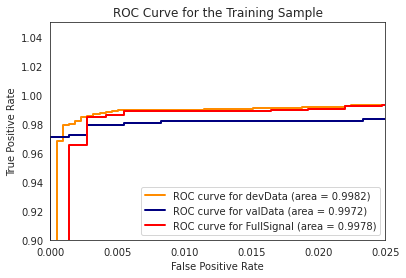

In [ ]:
from sklearn.metrics import roc_curve
plt.figure()
#roc_curve(real_value, NN_score)
lw = 2
fprdev, tprdev, thresholdsdev = roc_curve(y_class_train,pred_train)
plt.plot(fprdev,tprdev,color='darkorange',lw=lw, label='ROC curve for devData (area = %0.4f)' % devAUC)
fprval, tprval, thresholdsval = roc_curve(y_class_val,pred_val)
plt.plot(fprval, tprval, color='navy', lw=lw, label='ROC curve for valData (area = %0.4f)' % valAUC)
fprfull, tprfull, thresholdfull = roc_curve(y_class_test,pred_test)
plt.plot(fprfull, tprfull, color='red', lw=lw, label='ROC curve for FullSignal (area = %0.4f)' % testAUC)
plt.xlim([0.0, 0.025])
plt.ylim([0.9, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for the Training Sample")
plt.legend(loc="lower right")
plt.show()

## Aplying the NN to the data set in order to obtain the probabilities of being signal 

### This is for binary selection

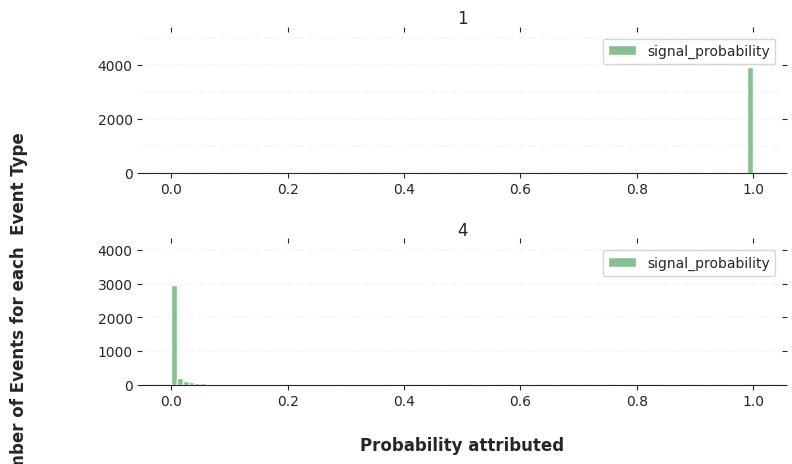

In [15]:
#Appending the score provided by the NN to the full dataset
FullSignal['signal_probability'] = pandas.Series(pred_full_Data[:,0])

#Printing out histograms with the score predictions for each event type
feature = ' Event Type'
# Little renaming of the Event Type variable from an int to a str to be prettier on the automatic plots
EventType = {1:'Heavy Neutral Lepton',2:'Dark Photon', 4:'Neutrino DIS'}
#for index, entry in enumerate(FullSignal[' Event Type']):
 # FullSignal[' Event Type'][index] = EventType[entry]

ax = FullSignal.hist(column='signal_probability', by=feature, bins=100, grid=False, figsize=(8,16), layout=(6,1), sharex=True, color='#86bf91', zorder=2, rwidth=1.0, log=False, legend=True, sharey=False)


for i,x in enumerate(ax):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set x-axis label
    x.set_xlabel("Probability attributed", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    if i == 1:
        x.set_ylabel("Number of Events for each "+feature, labelpad=50, weight='bold', size=12)
        


    x.tick_params(axis='x', rotation=0)

In [17]:
#print(FullSignal['signal_probability'].max())
#print(FullSignal['signal_probability'][FullSignal[' Event Type'] == 4].max())

#Max = FullSignal['signal_probability'][FullSignal[' Event Type'] == 4].max()
#Threshold = Max

#SurvivingSignal=FullSignal[(FullSignal["signal_probability"] > Threshold) & (FullSignal[" Event Type"] != 4)]
#SurvivingBackground=FullSignal[(FullSignal["signal_probability"] > Threshold) & (FullSignal[" Event Type"] == 4)]

#print("There are " + str(len(SurvivingSignal)) + " true  positives and " + str(len(SurvivingBackground)) + " false positives.")
#print("This leads to a total selection efficiency of " + str(len(SurvivingSignal)/len(FullSignal)))

efficiency = 0.95
for n in range (0,1000):
    Threshold=1-n*0.001
    SurvivingSignal=FullSignal[(FullSignal["signal_probability"]>Threshold) & (FullSignal[" Event Type"] != 4)]
    if len(SurvivingSignal)/len(Signal)>efficiency:
        break
        
print("The threshold to keep the selection efficiency of the signal at "+ str(efficiency*100) +"% is " + str(Threshold))

SurvivingSignal=FullSignal[(FullSignal["signal_probability"] > Threshold) & (FullSignal[" Event Type"] != 4)]
SurvivingBackground=FullSignal[(FullSignal["signal_probability"] > Threshold) & (FullSignal[" Event Type"] == 4)]

print("There are " + str(len(SurvivingSignal)) + " true  positives and " + str(len(SurvivingBackground)) + " false positives.")
print("This leads to a total selection efficiency of " + str(len(SurvivingSignal)/len(Signal)))
print("There is, however, a background efficiency of " + str(len(SurvivingBackground)/len(Background))+"\n\n")


#///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

maxbkg=10
for n in range (0,1000):
    Threshold=1-n*0.001
    SurvivingBackground=FullSignal[(FullSignal["signal_probability"]>Threshold) & (FullSignal[" Event Type"] == 4)]
    if len(SurvivingBackground)>maxbkg:
      Threshold+=0.001
      break
        
print("The threshold to keep a max of "+ str(maxbkg) +" surviving background events is " + str(Threshold))

SurvivingSignal=FullSignal[(FullSignal["signal_probability"] > Threshold) & (FullSignal[" Event Type"] != 4)]
SurvivingBackground=FullSignal[(FullSignal["signal_probability"] > Threshold) & (FullSignal[" Event Type"] == 4)]

print("There are " + str(len(SurvivingSignal)) + " true  positives and " + str(len(SurvivingBackground)) + " false positives.")
print("This leads to a total selection efficiency of " + str(len(SurvivingSignal)/len(Signal)))
print("There is, however, a background efficiency of " + str(len(SurvivingBackground)/len(Background))+"\n\n")

The threshold to keep the selection efficiency of the signal at 95.0% is 0.983
There are 3956 true  positives and 1 false positives.
This leads to a total selection efficiency of 0.9502762430939227
There is, however, a background efficiency of 0.0002748007694421544


The threshold to keep a max of 10 surviving background events is 0.922
There are 4031 true  positives and 10 false positives.
This leads to a total selection efficiency of 0.9682920970454
There is, however, a background efficiency of 0.0027480076944215444


